# import¶

In [1]:
# include working dir
# !conda install -y gdown
!conda search gdown
!pip install gdown
!gdown --id 14bHRkSgtEq-6exDKI5g9qJvfQ2708f8f
!gdown --id 1AuEFWdl1PumKEjv9z4lJ_JH78KRWdQ8g
!gdown --id 1A4cmVyIDTq23yHt-8IeIUDAJNzaLhmGw
!gdown --id 1AH3tuqJuKxZGPl2S6FBUD7KSmQbDUNPa
!gdown --id 1Ag_k3lrVjehCY-yraQJbw9Bxci0A_7Ni
!gdown --id 1Aoxrvc1ffIHZ4aM0azlU877ELLn9Lzw2
!gdown --id 1AEjAyc2mRbAWXgEOR1KujTZxh6997cdg
!gdown --id 1A-7ztu0KEG5opaOFBXHyg0XKV9yiraO-
!gdown --id 19viRSGCZ0dEtV7E2AS1Vn8vJbwH3tUKf
!gdown --id 1AQGDZtSkp-QNQNQUwl7MKz0iKmDZBFrJ
!gdown --id 1AAem6_anj1HM55_G09S4-HdZZPFelEjg
!gdown --id 1AWE3bJBuvALv75WcKb2yu8QAPq4cudei

Loading channels: done
# Name                       Version           Build  Channel             
gdown                          3.8.2            py_0  conda-forge         
gdown                          3.8.3            py_0  conda-forge         
gdown                          3.9.0            py_0  conda-forge         
gdown                         3.10.1            py_0  conda-forge         
gdown                         3.10.2    pyh9f0ad1d_0  conda-forge         
gdown                         3.10.3    pyh9f0ad1d_0  conda-forge         
gdown                         3.11.0    pyh9f0ad1d_0  conda-forge         
gdown                         3.11.1    pyh9f0ad1d_0  conda-forge         
gdown                         3.12.0    pyh9f0ad1d_0  conda-forge         
gdown                         3.12.2    pyh9f0ad1d_0  conda-forge         
gdown                         3.13.0    pyhd8ed1ab_0  conda-forge         
gdown                         3.13.1    pyhd8ed1ab_0  conda-forge         
gd

In [4]:
import os
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras.initializers import glorot_uniform
from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau, CSVLogger, EarlyStopping
from keras.models import Model, load_model, Sequential
from keras.layers import (
    Input, Conv1D, Dense, Dropout, MaxPooling1D, BatchNormalization, Activation, Reshape, Embedding, 
    GlobalAveragePooling1D, Concatenate, LayerNormalization, Attention, Add, Permute, ZeroPadding1D, 
    AveragePooling1D, Flatten, GlobalMaxPooling1D, MaxPool1D, MultiHeadAttention
)
from keras.utils import plot_model

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
# fix random seed for reproducibility
seed = 42
np.random.seed(seed)

In [6]:
# Load CSV files into a list
csv_files = ['train_data0.csv.gz', 'train_data1.csv.gz', 'train_data2.csv.gz', 'train_data3.csv.gz', 'train_data4.csv.gz', 
             'train_data5.csv.gz', 'train_data6.csv.gz', 'train_data7.csv.gz', 'train_data8.csv.gz', 'train_data9.csv.gz']

# Baseline Model

In [8]:
input_shape = (400, 1)
num_classes = 4

In [9]:
def prepare_df(f):
    df = pd.read_csv(f, compression='gzip')
    # shuffle the dataframe
    df = df.sample(frac=1).reset_index(drop=True)
    # split train data to input X and output y    
    X = df.drop(columns='output')
    y = df['output']
    # encode class values as integers
    y = pd.get_dummies(y, ['output'])
    # Convert all columns to floats
    y = y.astype(float)
    return [X, y]  

In [10]:
train_data_list = [prepare_df(f) for f in csv_files]

In [11]:
# define a callback functions
def getCallbacks(checkpoint_filename):
    early_stopping = EarlyStopping(
        monitor='val_accuracy', # quantity to monitor
        patience=3, # number of epochs with no improvement before stopping
        verbose=1 # print messages about the early stopping process
    ) 
    return [early_stopping]

## Train Model & Set parameter

In [12]:
class PositionalEncoding(Layer):
    def __init__(self, sequence_length, embedding_dimension):
        super(PositionalEncoding, self).__init__()
        self.encoding = self.positional_encoding(sequence_length, embedding_dimension)
        
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'encoding': self.encoding
        })
        return config
        
    def call(self, inputs):
        return inputs + self.encoding[:, :tf.shape(inputs)[1], :]
    
    def positional_encoding(self, sequence_length, embedding_dimension):
        encoding = np.zeros((sequence_length, embedding_dimension))
        for pos in range(sequence_length):
            for i in range(embedding_dimension):
                if i % 2 == 0:
                    encoding[pos, i] = np.sin(pos / 10000**(2*i/embedding_dimension))
                else:
                    encoding[pos, i] = np.cos(pos / 10000**(2*(i-1)/embedding_dimension))
        encoding = tf.constant(encoding, dtype=tf.float32)
        return tf.expand_dims(encoding, axis=0)
    
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout_rate):
    # Input Embedding
    x = Embedding(input_dim=800, output_dim=16)(inputs)
    
    # positional encoding
    x = PositionalEncoding(800, 16)(x)
 
    # Multi-Head Attention
    for i in range(num_heads):
        # Multi-Head Attention
        Q = Conv1D(head_size, 1, activation=None)(x)
        K = Conv1D(head_size, 1, activation=None)(x)
        V = Conv1D(head_size, 1, activation=None)(x)
        attention_out = Attention(use_scale=True, dropout=dropout_rate)([Q, K, V])
        attention_out = Dropout(dropout_rate)(attention_out)
        # Add and Norm
        attention_out = Dense(x.shape[-1])(attention_out)
        attention_out = Add()([x, attention_out])
        attention_out = LayerNormalization()(attention_out)
        # Feedforward
        ff_out = Conv1D(ff_dim, 1, activation='gelu')(attention_out)
        ff_out = Dropout(dropout_rate)(ff_out)
        ff_out = Conv1D(ff_dim, 1, activation=None)(ff_out)
        ff_out = Dropout(dropout_rate)(ff_out)
        # Add and Norm
        ff_out = Dense(attention_out.shape[-1])(ff_out)
        x = Add()([attention_out, ff_out])
        x = LayerNormalization()(x)
    return x


def build_model(input_shape, num_classes):
    head_size = 32
    num_heads = 8
    ff_dim = 64
    dropout_rate = 0.1
    
    # Define the input layer
    inputs = Input(shape=input_shape)

    # Define the convolutional layers
    x = Conv1D(8, 5, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(2)(x)

    x = Conv1D(10, 5, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(2)(x)

    x = Conv1D(16, 5, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(2)(x)

    # Reshape the output of the convolutional layers for the Transformer encoder
    x = Reshape((800,))(x)

    # Apply the Transformer encoder
    x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout_rate)

    # Pool over the time dimension and apply a fully connected layer
    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.5)(x)
    x = Dense(num_classes, activation='softmax')(x)

    # Create the Keras model
    model = Model(inputs=inputs, outputs=x)
    return model

In [31]:
# Initialize the KFold cross-validator
kfold = KFold(n_splits=10, shuffle=True) 
val_acc_list = []
models = []
lr = 1e-5
batch_size = 50
num_epochs = 6
opt = Adam(lr)

model = build_model(input_shape, num_classes)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [32]:
# Define the number of folds for cross-validation
n_folds = 10

# Use KFold to split the data into n_folds number of train-test pairs
kf = KFold(n_splits=n_folds)

# Loop through each fold and split the data
for i, (train_index, val_index) in enumerate(kf.split(train_data_list)):
    
    # Split the data into train and test sets
    train_files = [train_data_list[j] for j in train_index]
    val_file = train_data_list[val_index[0]] 

    # Load the train and test data
    X_train, y_train = pd.concat([X for X, y in train_files]), pd.concat([y for X, y in train_files])
    X_val, y_val = val_file  
    
    # Define the filename for the model checkpoint
    checkpoint_filename = f'W_model_fold{i+1}.h5'
    checkfile_exit = f'/kaggle/input/pretrained/W_model_fold{i+1}.h5'
    
    if not os.path.isfile(checkfile_exit):
        # Train the model on the train data
        model.fit(X_train, y_train, callbacks=getCallbacks(checkpoint_filename), validation_data=(X_val, y_val), epochs=num_epochs, batch_size=batch_size)
        model.save_weights(checkpoint_filename)
    else:
        # Load the best model from the checkpoint file
        # Load the saved weights into a new instance of the model
        model = build_model(input_shape, num_classes)
        model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
        model.load_weights(checkfile_exit)  

    scores = model.evaluate(X_val, y_val, verbose=0)
    print(f'Fold {i+1}: Validation loss: {scores[0]} - Validation accuracy: {scores[1]}')    
    
    # Append the accuracy score and model to the list of scores and models
    val_acc_list.append(scores[1] * 100)

    models.append(model)
    
    # Print the results 
    print(f"Fold {i+1}: Trained on {len(train_files)} files, tested on {val_index}")


Fold 1: Validation loss: 1.1838370561599731 - Validation accuracy: 0.4832484722137451
Fold 1: Trained on 9 files, tested on [0]
Fold 2: Validation loss: 0.8371399641036987 - Validation accuracy: 0.578420102596283
Fold 2: Trained on 9 files, tested on [1]
Fold 3: Validation loss: 0.7443937659263611 - Validation accuracy: 0.6709640622138977
Fold 3: Trained on 9 files, tested on [2]
Fold 4: Validation loss: 0.4650980830192566 - Validation accuracy: 0.8137214779853821
Fold 4: Trained on 9 files, tested on [3]
Fold 5: Validation loss: 0.9751355051994324 - Validation accuracy: 0.6542125344276428
Fold 5: Trained on 9 files, tested on [4]
Fold 6: Validation loss: 0.530501127243042 - Validation accuracy: 0.8256281614303589
Fold 6: Trained on 9 files, tested on [5]
Fold 7: Validation loss: 0.9942411780357361 - Validation accuracy: 0.5906141996383667
Fold 7: Trained on 9 files, tested on [6]
Fold 8: Validation loss: 0.507453978061676 - Validation accuracy: 0.8038676381111145
Fold 8: Trained on 9 

In [49]:
# Step 7: calculate overall performance metrics by averaging the results from all folds 
avg_val_acc = np.mean(val_acc_list) 
print(f'Overall validation accuracy: {avg_val_acc:.4f}')

# Save the best model val
val_best_model_index = np.argmax(val_acc_list)
val_best_model = models[val_best_model_index]
val_best_model.save_weights("val_best_model.h5")

Overall validation accuracy: 67.3776


## Visualize 10 Cross Validation Accuarcy

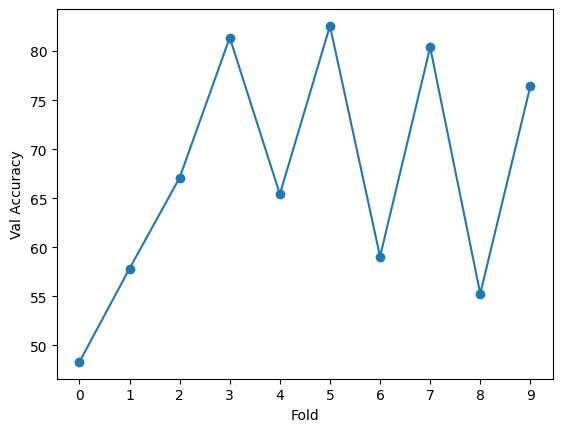

In [48]:
# Plot training and validation accuracy over epochs 
x = np.arange(0,10,1) 
plt.plot(val_acc_list, label='Validation Accuracy')
plt.scatter(x, val_acc_list, label='Validation Accuracy')
plt.xlabel('Fold')
plt.ylabel('Val Accuracy') 
plt.xticks(x) 

plt.show()

## Visualize Model Training History

In [71]:
# Load the saved weights into a new instance of the model
best_model = build_model(input_shape, num_classes)
best_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
best_model.load_weights('/kaggle/input/pretrained/W_model_fold7.h5')

In [51]:
print(best_model.summary())

Model: "model_42"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_43 (InputLayer)          [(None, 400, 1)]     0           []                               
                                                                                                  
 conv1d_1806 (Conv1D)           (None, 400, 8)       48          ['input_43[0][0]']               
                                                                                                  
 batch_normalization_126 (Batch  (None, 400, 8)      32          ['conv1d_1806[0][0]']            
 Normalization)                                                                                   
                                                                                                  
 activation_126 (Activation)    (None, 400, 8)       0           ['batch_normalization_126[

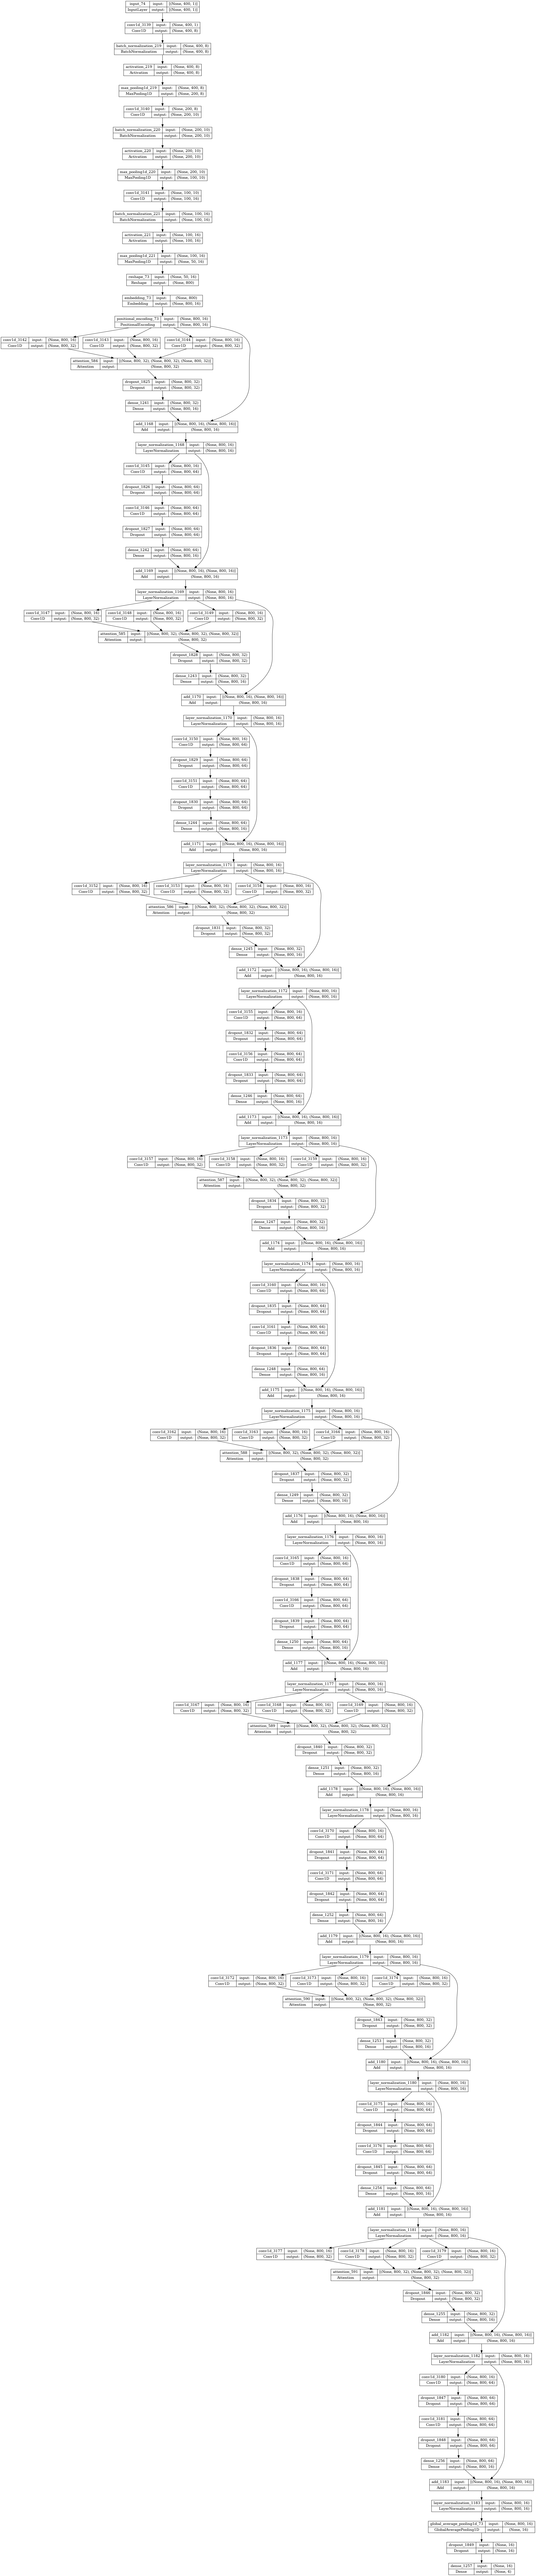

In [81]:
# Visualize the model architecture
plot_model(best_model, to_file='model2.png', show_shapes=True)  

## Evaluate Model

In [62]:
test_acc_list = []
for i in range(10):
    # Load the saved weights into a new instance of the model
    test_model = build_model(input_shape, num_classes)
    test_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    test_model.load_weights(f'/kaggle/input/pretrained/W_model_fold{i+1}.h5')
    
    
    Test_df = pd.read_csv('test_data.csv.gz', compression='gzip') 
    # split validation data to input X and output y    
    X_test = Test_df.drop(columns='output')
    y_test = Test_df['output']
    # encode class values as integers
    y_test = pd.get_dummies(y_test, ['output'])
    # Convert all columns to floats
    y_test = y_test.astype(float)
    scores = test_model.evaluate(X_test, y_test, verbose=0)
    print(f'Testing loss: {scores[0]} - Testing accuracy: {scores[1]}')
    print("==========================================================")
    
    # Append the accuracy score and model to the list of scores and models
    test_acc_list.append(scores[1] * 100)

Testing loss: 0.9596084356307983 - Testing accuracy: 0.6044906973838806
Testing loss: 0.8776874542236328 - Testing accuracy: 0.6166583299636841
Testing loss: 0.6755680441856384 - Testing accuracy: 0.7101103663444519
Testing loss: 0.6143578886985779 - Testing accuracy: 0.7117410898208618
Testing loss: 0.5903317928314209 - Testing accuracy: 0.7574009299278259
Testing loss: 0.5955726504325867 - Testing accuracy: 0.7769693732261658
Testing loss: 0.517312228679657 - Testing accuracy: 0.8001756072044373
Testing loss: 0.5521376729011536 - Testing accuracy: 0.7866281867027283
Testing loss: 0.5613904595375061 - Testing accuracy: 0.7868790626525879
Testing loss: 0.5840134024620056 - Testing accuracy: 0.7962870001792908


## Testing Best Model

In [72]:
Test_df = pd.read_csv('test_data.csv.gz', compression='gzip') 
# split validation data to input X and output y    
X_test = Test_df.drop(columns='output')
y_test = Test_df['output']
# encode class values as integers
y_test = pd.get_dummies(y_test, ['output'])
# Convert all columns to floats
y_test = y_test.astype(float)
scores = best_model.evaluate(X_test, y_test, verbose=0)
print(f'Testing loss: {scores[0]} - Testing accuracy: {scores[1]}')

Testing loss: 0.517312228679657 - Testing accuracy: 0.8001756072044373


## Visualize Testing Accuarcy Vs Validation Accuarcy Vs Fold model

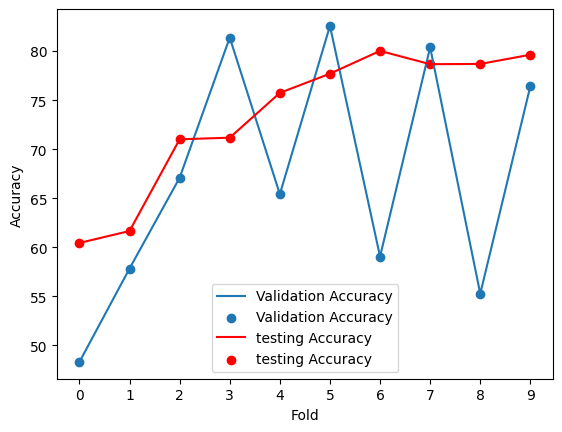

In [69]:
# Plot training and validation accuracy over epochs 
x = np.arange(0,10,1) 
plt.plot(val_acc_list, label='Validation Accuracy')
plt.scatter(x, val_acc_list, label='Validation Accuracy')
plt.plot(test_acc_list, label='testing Accuracy', c='r')
plt.scatter(x, test_acc_list, label='testing Accuracy', c='r')
plt.xlabel('Fold')
plt.ylabel('Accuracy') 
plt.xticks(x) 
plt.legend()

plt.show()

## Visualize insights of Model

In [73]:
#importing confusion matrix
from sklearn.metrics import multilabel_confusion_matrix
y_pred = best_model.predict(X_test).round()
confusion = multilabel_confusion_matrix(y_test, y_pred)
print('Confusion Matrix\n')
print(confusion)

#importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test, y_pred, target_names=['output_CAD', 'output_CHF', 'output_MI', 'output_Normal']))

250/250 [==============================] - 14s 48ms/step
Confusion Matrix

[[[5861  118]
  [ 231 1762]]

 [[5110  869]
  [ 307 1686]]

 [[5659  320]
  [ 940 1053]]

 [[5824  155]
  [ 176 1817]]]

Accuracy: 0.79

Micro Precision: 0.81
Micro Recall: 0.79
Micro F1-score: 0.80

Macro Precision: 0.82
Macro Recall: 0.79
Macro F1-score: 0.80

Weighted Precision: 0.82
Weighted Recall: 0.79
Weighted F1-score: 0.80

Classification Report

               precision    recall  f1-score   support

   output_CAD       0.94      0.88      0.91      1993
   output_CHF       0.66      0.85      0.74      1993
    output_MI       0.77      0.53      0.63      1993
output_Normal       0.92      0.91      0.92      1993

    micro avg       0.81      0.79      0.80      7972
    macro avg       0.82      0.79      0.80      7972
 weighted avg       0.82      0.79      0.80      7972
  samples avg       0.79      0.79      0.79      7972



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


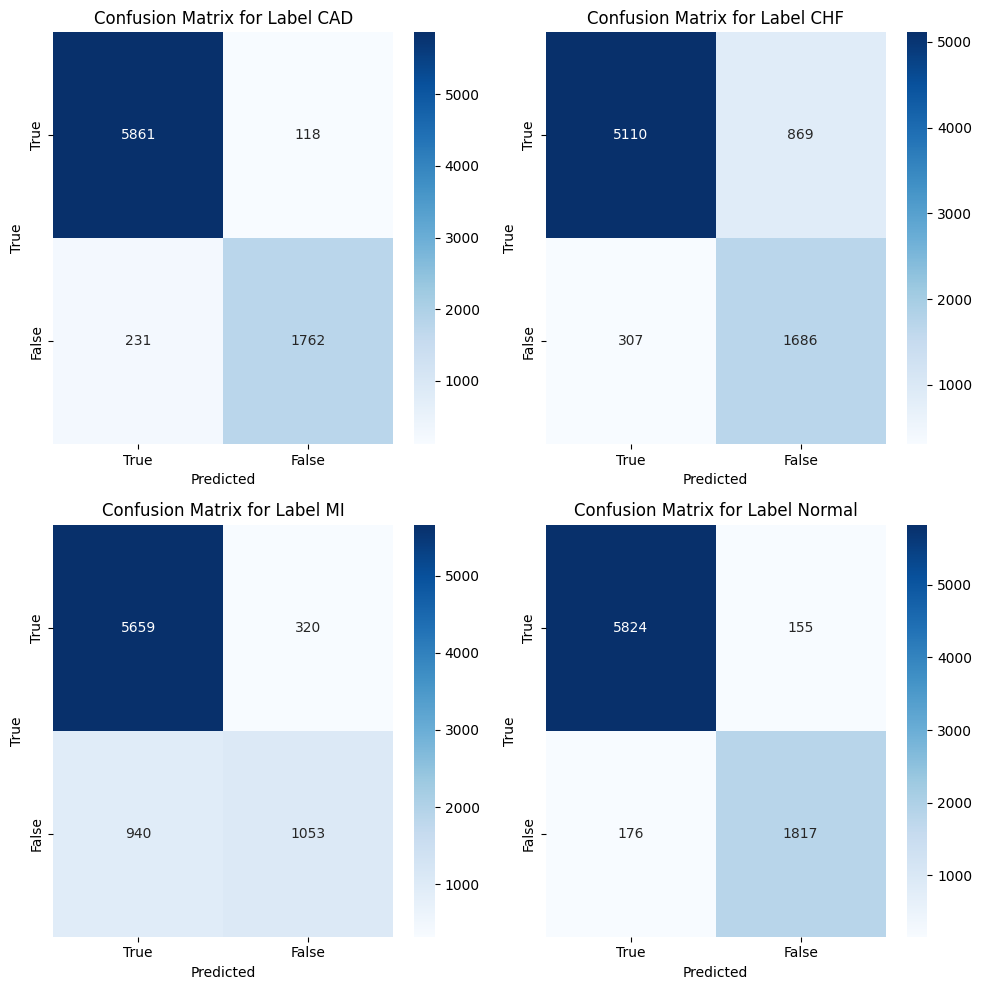

In [74]:
labels = ['CAD', 'CHF', 'MI', 'Normal']
# Create a heatmap of the confusion matrix
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for i, ax in enumerate(axs.flat):
    sns.heatmap(confusion[i], annot=True, cmap='Blues', fmt='g', xticklabels=['True', 'False'], yticklabels=['True', 'False'], ax=ax)
    ax.set_title('Confusion Matrix for Label ' + labels[i])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

plt.tight_layout()
plt.show()

## Communication using case study

In [75]:
X_test.iloc[300:301,:]

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
300,-0.1958,-0.18636,-0.17612,-0.17044,-0.16532,-0.1746,-0.18484,-0.17996,-0.17516,-0.18028,...,-0.16412,-0.159,-0.15388,-0.14876,-0.1382,-0.1126,-0.0566,0.06628,0.18732,0.30508


In [76]:
y_test.iloc[300:301,:]

,['output']_CAD,['output']_CHF,['output']_MI,['output']_Normal
300,0.0,0.0,0.0,1.0


In [77]:
# test_model
# test_case = pd.read_csv("/kaggle/input/testdata/Book2.csv")
pred = best_model.predict(X_test.iloc[300:301,:]).round()
# ['output']_CAD	['output']_CHF	['output']_MI	['output']_Normal
out_col = ['output_CAD', 'output_CHF', 'output_MI', 'output_Normal']
output = {out_col[i]:pred[0][i] for i in range(4)}
output_class = max(output, key=output.get).split('_')[-1]
"output_class = " + output_class

1/1 [==============================] - 0s 36ms/step


'output_class = Normal'

# End Model Training Notebook